# MaLSTM

 - LSTM은 순서가 잇는 입력 데이터에 적합하다는 평을 받는 순환 신경망 기반의 모델이다.
 
 
 - LSTM 계열은 문장의 시퀀스(Sequence) 형태로 학습시키고 기존 순환 신경망보다 장기적인 학습에 효과적인 성능을 보여줬다.
 
 
 - 그중에서 유사도를 구하기 위해 활용하는 대표적인 모델인 MaLSTM 모델은 2016년 MIT에서 조나스 뮐러가 쓴 논문에서 소개되었다.
 
 
 - MaLSTM이란 매하탄 거리(Manhattan Distnace) + LSTM의 줄입말로써, 일반적인 문장의 유사도를 계산할 때 코사인 유사도를 사용하는 대신 맨하탄 거리를 사용하는 모델이다.

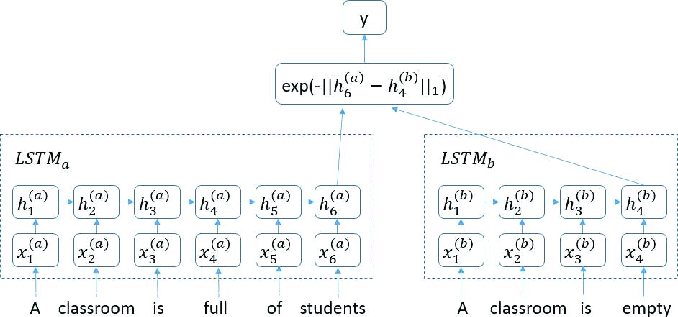

In [1]:
from IPython.display import Image
Image("Image/MaLSTM.jpg")

 - 이전의 합성곱 신경망 모댈은 두 개의 문장 입력값에 대해 각각 합성곱 층을 적용한 후 최종적으로 각 문장에 대해 의미 벡터를 각각 뽑아내서 이 둘의 값을 맨하탄 거리로 비교하는 형태의 모델이었다. MaLSTM 역시 이와 거의 비슷한 구조로 되어 있는데, 여기서는 합성곱 레이어를 적용해 보는 것이 아니라 순환 신경망 기반의 LSTM 층을 적용해 각 문장의 의미 벡터를 뽑는다.
 
 
 - 해당 모델의 의미 벡터는 각 KSTM의 마지막 스텝인 $LSTM_a$의 ${h_3}^{(a)}$ 값과 $LSTM_b$의 ${h_3}^{(b)}$ 값이 은닉 상태 벡터로 사용된다. 이 값의 문장은 모든 단어에 대한 정보가 반영된 값으로 전체 문장을 대표하는 벡터가 된다. 이렇게 뽑은 두 벡터에 대해 맨하탄 거리를 계산해서 두 문장 사이의 유사도를 측정한다. 그리고 이렇게 계산한 유사도를 실제 라벨과 비교해서 학습하는 방식이다.

In [2]:
# 라이브러리
import sys
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import json

In [3]:
# 데이터 디렉터리 및 파일명 지정
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'


# 하이퍼 파라미터 설정
BATCH_SIZE = 16
EPOCH = 2
HIDDEN = 64
BUFFER_SIZE = 10000
NUM_LAYERS = 3
DROPOUT_RATIO = 0.3
TEST_SPLIT = 0.1
RNG_SEED = 13371447
EMBEDDING_DIM = 128
MAX_SEQ_LEN = 31

In [4]:
# 데이터 불러오기
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = None

with open(DATA_IN_PATH + DATA_CONFIGS, 'r') as f:
    prepro_configs = json.load(f)
    
VOCAB_SIZE = prepro_configs['vocab_size']

In [5]:
# 
q1_data_len = np.array([min(len(x), MAX_SEQ_LEN) for x in q1_data])
q2_data_len = np.array([min(len(x), MAX_SEQ_LEN) for x in q2_data])

In [6]:
# 데이터 분리
# 데이터를 나누어 저장하자. sklearn의 train_test_split을 사용하면 유용하다. 하지만, 쿼라 데이터의 경우는
## 입력이 1개가 아니라 2개이다. 따라서, np.stack을 사용하여 두개를 하나로 쌓은다음 활용하여 분류한다.
X = np.stack((q1_data, q2_data), axis=1)
y = labels
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
train_Q1 = train_X[:,0]
train_Q2 = train_X[:,1]
test_Q1 = test_X[:,0]
test_Q2 = test_X[:,1]

In [7]:
# 모델 입력 함수 생성
def rearrange(base, hypothesis, labels):
    features = {"base": base, "hypothesis": hypothesis}
    return features, labels

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((train_Q1, train_Q2, train_y))
    dataset = dataset.shuffle(buffer_size=len(train_Q1))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(rearrange)
    dataset = dataset.repeat(EPOCH)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_Q1, test_Q2, test_y))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(rearrange)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [8]:
# 모델 함수
def Malstm(features, labels, mode):
        
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT
    
    # 입력값을 임베딩 값으로 바꾼다.
    embedding = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
    base_embedded_matrix = embedding(features['base'])
    hypothesis_embedded_matrix = embedding(features['hypothesis'])
    
    # 양방향 LSTM을 사용한다. 정방향 LSTM층과 역방향 LSTM 층을 사용한다.
    # 우선 BasicLSTMCell 객체를 정의하고, 입력값으로 LSTM 은닉 상태 벡터의 차원수와 활성화 함수를 설정한다.
    # 이렇게 데이터를 적용한 후 결과값을 하나로 합친다.
    
    # Question 1에 대한 LSTM모델
    q_lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = 64, activation = tf.nn.tanh)
    q_lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = 64, activation = tf.nn.tanh)
    _, q_output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw = q_lstm_fw_cell,
                                                       cell_bw = q_lstm_bw_cell,
                                                       inputs = base_embedded_matrix,
                                                       dtype = tf.float32,
                                                      scope='query')
    # 마지막 state 값을 뽑아 추출한다
    q_final_state = tf.concat([q_output_states[0].h, q_output_states[1].h], axis=1)

    # Question 2 (유사한 쿼리)에 대한 LSTM모델
    s_lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = 64, activation = tf.nn.tanh)
    s_lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units = 64, activation = tf.nn.tanh)
    _, s_output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw = s_lstm_fw_cell,
                                                       cell_bw = s_lstm_bw_cell,
                                                       inputs = hypothesis_embedded_matrix,
                                                        dtype = tf.float32,
                                                      scope='sim_query')
    
    # 양방향 순환 신경망 함수의 경우 두 개의 리턴값이 있는데, 하나는 순호나 신경망의 출력값이고, 나머지 하나는
    # 순환 신경망 마지막 스텝의 은닉상태 벡터값이다.
    
    # 은닉 상태 벡터 값이 필요하므로 추출한다.
    
    #LSTM의 마지막 state 값을 추출한다.
    sim_final_state = tf.concat([s_output_states[0].h, s_output_states[1].h], axis=1)
           
    # 위의 코드의 경우 양항뱡 LSTM을 통해 앞뒤 정보를 담은 마지막 은닉 상태 벡터를 얻는 형식으로 기존 문장과
    # 대상 문장의 의미 벡터를 모두 구했다.
    
    # 이제 이 의미 벡터로 맨하탄 거리를 계산해서 두 문장 사이의 유사도를 측정하면 된다.
    
#     merged_matrix = tf.concat([base_sementic_matrix, hypothesis_sementic_matrix], -1)
#     logit_layer = tf.keras.layers.dot([base_sementic_matrix, hypothesis_sementic_matrix], axes=1, normalize=True)    

    with tf.variable_scope('output_layer'):
#     logit_layer = K.exp(-K.sum(K.abs(base_sementic_matrix - hypothesis_sementic_matrix), axis=1, keepdims=True))
        logit_layer = tf.exp(-tf.reduce_sum(tf.abs(q_final_state - sim_final_state), axis=1, keepdims=True))
        logit_layer = tf.squeeze(logit_layer, axis=-1)
                
    if PREDICT:
        return tf.estimator.EstimatorSpec(
                  mode=mode,
                  predictions={
                      'is_duplicate':logit_layer
                  })
    
    #prediction 진행 시, None
    if labels is not None:
        labels = tf.to_float(labels)
    
#     loss = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(y_true=labels, y_pred=logit_layer))
    loss = tf.losses.mean_squared_error(labels=labels, predictions=logit_layer)
#     loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(labels, logit_layer))
    
    if EVAL:
        accuracy = tf.metrics.accuracy(labels, tf.round(logit_layer))
        eval_metric_ops = {'acc': accuracy}
        return tf.estimator.EstimatorSpec(
                  mode=mode,
                  eval_metric_ops= eval_metric_ops,
                  loss=loss)

    elif TRAIN:

        global_step = tf.train.get_global_step()
        train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(
                  mode=mode,
                  train_op=train_op,
                  loss=loss)

In [9]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0" #For TEST  

model_dir = os.path.join(os.getcwd(), DATA_OUT_PATH + "/checkpoint/rnn/")
os.makedirs(model_dir, exist_ok=True)

config_tf = tf.estimator.RunConfig(save_checkpoints_steps=500,
                                save_checkpoints_secs=None,
                                  keep_checkpoint_max=2,
                                  log_step_count_steps=200)

lstm_est = tf.estimator.Estimator(Malstm, model_dir=model_dir, config=config_tf)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\Desktop\\Natural Language Processing\\02. NLP_with_Tensorflow\\./data_out//checkpoint/rnn/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 200, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002AB92935278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
# 모델 훈련
lstm_est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 500 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:loss = 0.19501862, step = 501
INFO:tensorflow:global_step/sec: 9.84318
INFO:tensorflow:loss = 0.23339841, step = 701 (20.320 sec)
INFO:tensorflow:global_step/sec: 14.0588
INFO:tensorflow:loss = 0.

INFO:tensorflow:Saving checkpoints for 9500 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 10.7117
INFO:tensorflow:loss = 0.210753, step = 9501 (18.670 sec)
INFO:tensorflow:global_step/sec: 13.0489
INFO:tensorflow:loss = 0.18448265, step = 9701 (15.327 sec)
INFO:tensorflow:global_step/sec: 13.0829
INFO:tensorflow:loss = 0.20372422, step = 9901 (15.287 sec)
INFO:tensorflow:Saving checkpoints for 10000 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 10.5578
INFO:tensorflow:loss = 0.15714684, step = 10101 (18.944 sec)
INFO:tensorflow:global_step/sec: 12.9847
INFO:tensorflow:loss = 0.19346492, step = 10301 (15.403 sec)
INFO:tensorflow:Saving checkpoints for 10500 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:te

INFO:tensorflow:global_step/sec: 12.7025
INFO:tensorflow:loss = 0.13613686, step = 19301 (15.744 sec)
INFO:tensorflow:Saving checkpoints for 19500 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 10.384
INFO:tensorflow:loss = 0.17573929, step = 19501 (19.261 sec)
INFO:tensorflow:global_step/sec: 12.7066
INFO:tensorflow:loss = 0.18290448, step = 19701 (15.739 sec)
INFO:tensorflow:global_step/sec: 12.6449
INFO:tensorflow:loss = 0.12462133, step = 19901 (15.818 sec)
INFO:tensorflow:Saving checkpoints for 20000 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 9.90493
INFO:tensorflow:loss = 0.20608103, step = 20101 (20.191 sec)
INFO:tensorflow:global_step/sec: 12.7534
INFO:tensorflow:loss = 0.15999685, step = 20301 (15.682 sec)
INFO:tensorflow:Saving checkpoints for 20500 into C:\Users\user

INFO:tensorflow:global_step/sec: 10.4071
INFO:tensorflow:loss = 0.11761057, step = 29101 (19.219 sec)
INFO:tensorflow:global_step/sec: 12.7689
INFO:tensorflow:loss = 0.18351987, step = 29301 (15.662 sec)
INFO:tensorflow:Saving checkpoints for 29500 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 10.2986
INFO:tensorflow:loss = 0.2292492, step = 29501 (19.420 sec)
INFO:tensorflow:global_step/sec: 12.6568
INFO:tensorflow:loss = 0.100628704, step = 29701 (15.802 sec)
INFO:tensorflow:global_step/sec: 12.7607
INFO:tensorflow:loss = 0.1213766, step = 29901 (15.674 sec)
INFO:tensorflow:Saving checkpoints for 30000 into C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt.
INFO:tensorflow:global_step/sec: 10.2539
INFO:tensorflow:loss = 0.109354824, step = 30101 (19.504 sec)
INFO:tensorflow:global_step/sec: 12.7868
INFO:tensorflow:loss 

In [11]:
# 모델 평가
lstm_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-09-10:34:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt-34086
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-09-10:34:19
INFO:tensorflow:Saving dict for global step 34086: acc = 0.7913777, global_step = 34086, loss = 0.14709923
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 34086: C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt-34086


{'acc': 0.7913777, 'loss': 0.14709923, 'global_step': 34086}

In [12]:
# Test 데이터 불러오기
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'))

In [13]:
# 모델을 통한 에측
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"base":test_q1_data, 
                                                         "hypothesis":test_q2_data}, 
                                                      shuffle=False)
predictions = np.array([p['is_duplicate'] for p in lstm_est.predict(input_fn=predict_input_fn)])

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\Desktop\Natural Language Processing\02. NLP_with_Tensorflow\./data_out//checkpoint/rnn/model.ckpt-34086
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [14]:
# 결과 저장
print(len(predictions))

output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv( "rnn_predict.csv", index=False, quoting=3 )

2345796
